# Params

In [2]:
path = '../data/VPC/'
cores_path = path + 'Train/'
target_path = path + 'multiscale_patches_Train/'

# path = '../data/Biomax_TMA/' # path to the dataset
# cores_path = path + 'HnE/' # path to the images
# target_path = path + 'multiscale_patches/' # where to save the patches

# Import

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
from skimage import io
import random
from skimage.transform import resize

In [5]:
import math
import cv2
import torch
import torch.nn.functional as F

In [6]:
print("torch:", torch.__version__)
print("compiled_with_cuda:", torch.version.cuda)
print("cuda.is_available:", torch.cuda.is_available())
print("device_count:", torch.cuda.device_count())
print("device0:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)

torch: 2.4.1
compiled_with_cuda: 12.1
cuda.is_available: True
device_count: 1
device0: NVIDIA GeForce RTX 4090


# Utils

In [ ]:
# ---------- helpers ----------
def _ensure_dirs(path):
    os.makedirs(path, exist_ok=True)

def _pad_to_multiple_torch(img_t, size, pad_val=1.0):
    # img_t: [C,H,W], values in [0,1]
    C, H, W = img_t.shape
    pad_h = (-H) % size
    pad_w = (-W) % size
    # F.pad uses (left,right,top,bottom)
    if pad_h or pad_w:
        img_t = F.pad(img_t, (0, pad_w, 0, pad_h), mode='constant', value=pad_val)
    return img_t

def _pad_uniform_torch(img_t, pad, pad_val=1.0):
    # pad pixels on all sides
    if pad <= 0:
        return img_t
    return F.pad(img_t, (pad, pad, pad, pad), mode='constant', value=pad_val)

def _to_uint8_cpu(img_t):
    # img_t: [N,C,H,W] or [C,H,W], values in [0,1]
    if img_t.dim() == 3:
        img_t = img_t.unsqueeze(0)
    img_t = (img_t.clamp(0,1) * 255.0).round().to(torch.uint8).cpu().numpy()  # [N,C,H,W]
    # convert to HxWxC for OpenCV (expects BGR uint8)
    # our tensors are RGB, but you saved as PNG without explicit color mgmt.
    # We'll keep RGB to avoid color flips; cv2 will still write it fine if we don't convert.
    imgs = [np.transpose(x, (1,2,0)) for x in img_t]  # list of HxWxC
    return imgs

In [11]:
# torch padder that mimics your old np.pad (pads with white to multiple of size_like)
def padder_torch(img_np, size_like, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    t = torch.from_numpy(img_np).to(device).float() / 255.0          # [H,W,C]
    t = t.permute(2,0,1)                                             # [C,H,W]
    H, W = t.shape[1], t.shape[2]
    pad_h = (-H) % size_like
    pad_w = (-W) % size_like
    if pad_h or pad_w:
        t = F.pad(t, (0, pad_w, 0, pad_h), mode='constant', value=1.0)
    t = (t.clamp(0,1) * 255.0).round().byte().permute(1,2,0).cpu().numpy()
    return t

# Extracting

In [8]:
# ---------- main GPU extractor ----------
def patch_extractor_image_gpu(img_path, size, size_path, device='cuda', chunk_rows=None):
    """
    - Reads RGB image with cv2 (uint8)
    - Pads to multiple of 'size' with white
    - Produces 40x native patches (size x size)
      20x: crop (2*size)x(2*size) around each grid cell, then downsample to size
      10x: crop (4*size)x(4*size), then downsample to size
    - Saves to size_path/40, /20, /10 with names 'w_h.png'
    """
    # I/O
    img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if img_bgr is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # to tensor [C,H,W] in [0,1]
    img = torch.from_numpy(img_rgb).permute(2,0,1).float() / 255.0  # [3,H,W]

    # device
    use_cuda = torch.cuda.is_available() and (device == 'cuda')
    dev = torch.device('cuda' if use_cuda else 'cpu')
    img = img.to(dev, non_blocking=True)

    # 1) pad to multiple of size (white=1.0)
    img = _pad_to_multiple_torch(img, size, pad_val=1.0)  # [3,H’,W’]
    C, H, W = img.shape

    # 2) build padded versions for 20x and 10x
    img_20 = _pad_uniform_torch(img, size//2, pad_val=1.0)  # [3,H’+size, W’+size]
    img_10 = _pad_uniform_torch(img_20, size, pad_val=1.0)  # [3,H’+3/2*size, W’+3/2*size]

    # grid counts
    n_rows = H // size
    n_cols = W // size
    L = n_rows * n_cols

    # optional chunking to limit VRAM (process a few rows at a time)
    if chunk_rows is None or chunk_rows <= 0:
        chunk_rows = n_rows  # one shot

    # prepare output dirs
    p40_dir = os.path.join(size_path, '40')
    p20_dir = os.path.join(size_path, '20')
    p10_dir = os.path.join(size_path, '10')
    for d in (p40_dir, p20_dir, p10_dir):
        _ensure_dirs(d)

    # helpers to unfold a strip of rows
    def unfold_strip(img_t, k, rows_from, rows_to):
        # take only the strip area to reduce memory
        top = rows_from * size
        bottom = rows_to * size
        strip = img_t[:, top:bottom + (k - size), :]  # ensure enough height for kernel
        # F.unfold expects [N,C,H,W]
        strip_bchw = strip.unsqueeze(0)
        patches = F.unfold(strip_bchw, kernel_size=k, stride=size)  # [1, C*k*k, L_strip]
        B, CK2, Ls = patches.shape
        patches = patches.transpose(1,2).reshape(Ls, C, k, k)       # [L_strip, C, k, k]
        return patches, top  # also return starting h offset

    # main loop over chunks of rows
    for r0 in range(0, n_rows, chunk_rows):
        r1 = min(r0 + chunk_rows, n_rows)

        # 40x native
        p40, h_off = unfold_strip(img, size, r0, r1)            # [L40, C, S, S]
        # 20x: 2S crops from img_20 -> downsample to S
        p20, _ = unfold_strip(img_20, 2*size, r0, r1)           # [L20, C, 2S, 2S]
        p20 = F.interpolate(p20, size=(size, size), mode='bilinear', align_corners=True)
        # 10x: 4S crops from img_10 -> downsample to S
        p10, _ = unfold_strip(img_10, 4*size, r0, r1)           # [L10, C, 4S, 4S]
        p10 = F.interpolate(p10, size=(size, size), mode='bilinear', align_corners=True)

        # figure out filenames (w_h.png) for each local patch index
        # local rows in this chunk: r = r0..r1-1, cols: 0..n_cols-1
        local_L = (r1 - r0) * n_cols
        assert p40.shape[0] == local_L

        # convert to uint8 on CPU for saving
        imgs40 = _to_uint8_cpu(p40)  # list of HxWxC
        imgs20 = _to_uint8_cpu(p20)
        imgs10 = _to_uint8_cpu(p10)

        # write files
        idx = 0
        for rr in range(r0, r1):
            h_point = rr * size
            for cc in range(n_cols):
                w_point = cc * size
                fname = f"{w_point}_{h_point}.png"
                cv2.imwrite(os.path.join(p40_dir, fname), cv2.cvtColor(imgs40[idx], cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(p20_dir, fname), cv2.cvtColor(imgs20[idx], cv2.COLOR_RGB2BGR))
                cv2.imwrite(os.path.join(p10_dir, fname), cv2.cvtColor(imgs10[idx], cv2.COLOR_RGB2BGR))
                idx += 1

def path_constructor(img_file, target_path, size, magnifications):
    core_path = os.path.join(target_path, os.path.splitext(img_file)[0])
    os.makedirs(core_path, exist_ok=True)

    size_path = os.path.join(core_path, str(size))
    os.makedirs(size_path, exist_ok=True)

    for mag in magnifications:
        os.makedirs(os.path.join(size_path, str(mag)), exist_ok=True)

    return size_path



In [9]:
def patch_extractor_dataset_gpu(dataset_path, size, target_path, device='cuda', chunk_rows=None):
    magnifications = [10, 20, 40]
    for img_file in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, img_file)
        if not os.path.isfile(img_path):
            continue
        size_path = path_constructor(img_file, target_path, size, magnifications)
        patch_extractor_image_gpu(img_path, size, size_path, device=device, chunk_rows=chunk_rows)

In [10]:
patch_extractor_dataset_gpu(cores_path, 512, target_path, device='cuda', chunk_rows=8)

In [12]:
img_files = os.listdir(cores_path)
print(img_files[0][:-4])

slide003_core031


In [17]:
img_file

'slide005_core063.jpg'

slide005_core063.jpg
5120 5120
slide: 5 - core: 63


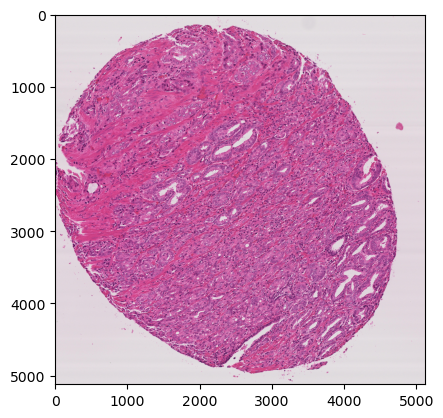

In [13]:
img_file = os.listdir(cores_path)[5]
print(img_file)
img = io.imread(cores_path + img_file)
plt.imshow(img)
h, w, _ = img.shape
print(h, w)
print('slide: {} - core: {}'.format(int(img_file[5:8]), int(img_file[-7:-4])))


(5500, 5500, 3)


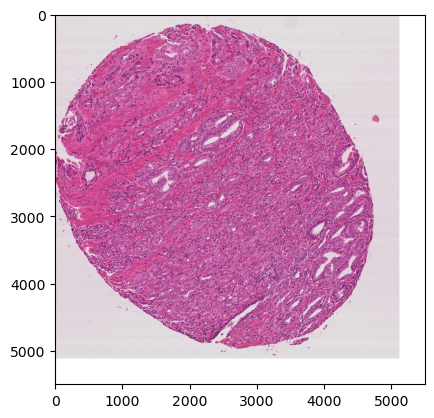

In [14]:
padded = padder_torch(img, 550)   # uses GPU if available
print(padded.shape)
plt.imshow(padded)

In [15]:
# output dir for 512 size
size = 512
temp_path = os.path.join(target_path, str(size))
os.makedirs(temp_path, exist_ok=True)
print("temp_path:", temp_path)

temp_path: ../data/VPC/multiscale_patches_Train/512
